In [195]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import feature
from skimage import segmentation
from skimage import restoration

from sklearn import preprocessing

from scipy import ndimage as ndi

from skimage.filters import threshold_multiotsu

## I/O

In [196]:
# img_raw = io.imread('13G_Diplo_0_05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new_0612.tif')
# img_raw = io.imread('13G_Srosetta_0_05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new_24.tif')
img_file = '/media/dzavadska/Elements/kineto_firstadequate_sample_set_Nov_2023/D44_Diplo_0.05mMDRAQ5200ngmlDAPI_63x_2PFA_thickstack_new-05(1).tif'
img_name = img_file.split('.')[0]

img_raw = io.imread(img_file)
print(img_raw.shape)

(8, 728, 968, 3)


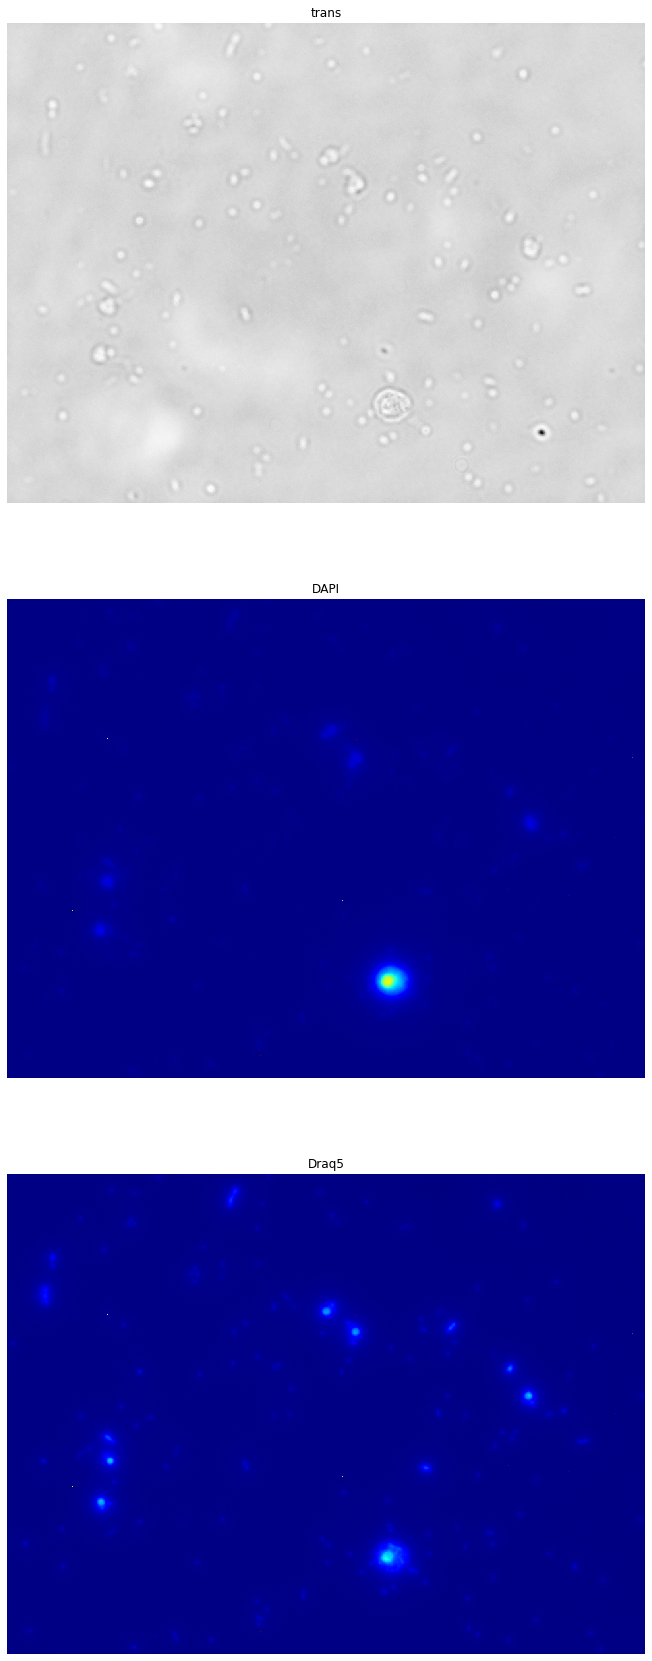

In [197]:
img_ch0 = img_raw[:,:,:,0]
img_ch1 = img_raw[:,:,:,1]
img_ch2 = img_raw[:,:,:,2]

img_trans = np.mean(img_ch0, axis=0)
img_dapi = np.sum(img_ch2, axis=0, dtype='int64')
img_draq = np.sum(img_ch1, axis=0, dtype='int64')


plt.figure(figsize=(30,30))

ax0 = plt.subplot(312)
ax0.imshow(img_dapi, cmap='jet')
ax0.set_title('DAPI')
ax0.axis('off')

ax1 = plt.subplot(311)
ax1.imshow(img_trans, cmap='Greys')
ax1.set_title('trans')
ax1.axis('off')

ax2 = plt.subplot(313)
ax2.imshow(img_draq, cmap='jet')
ax2.set_title('Draq5')
ax2.axis('off')

plt.show()

## Cells mask

/home/dzavadska/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


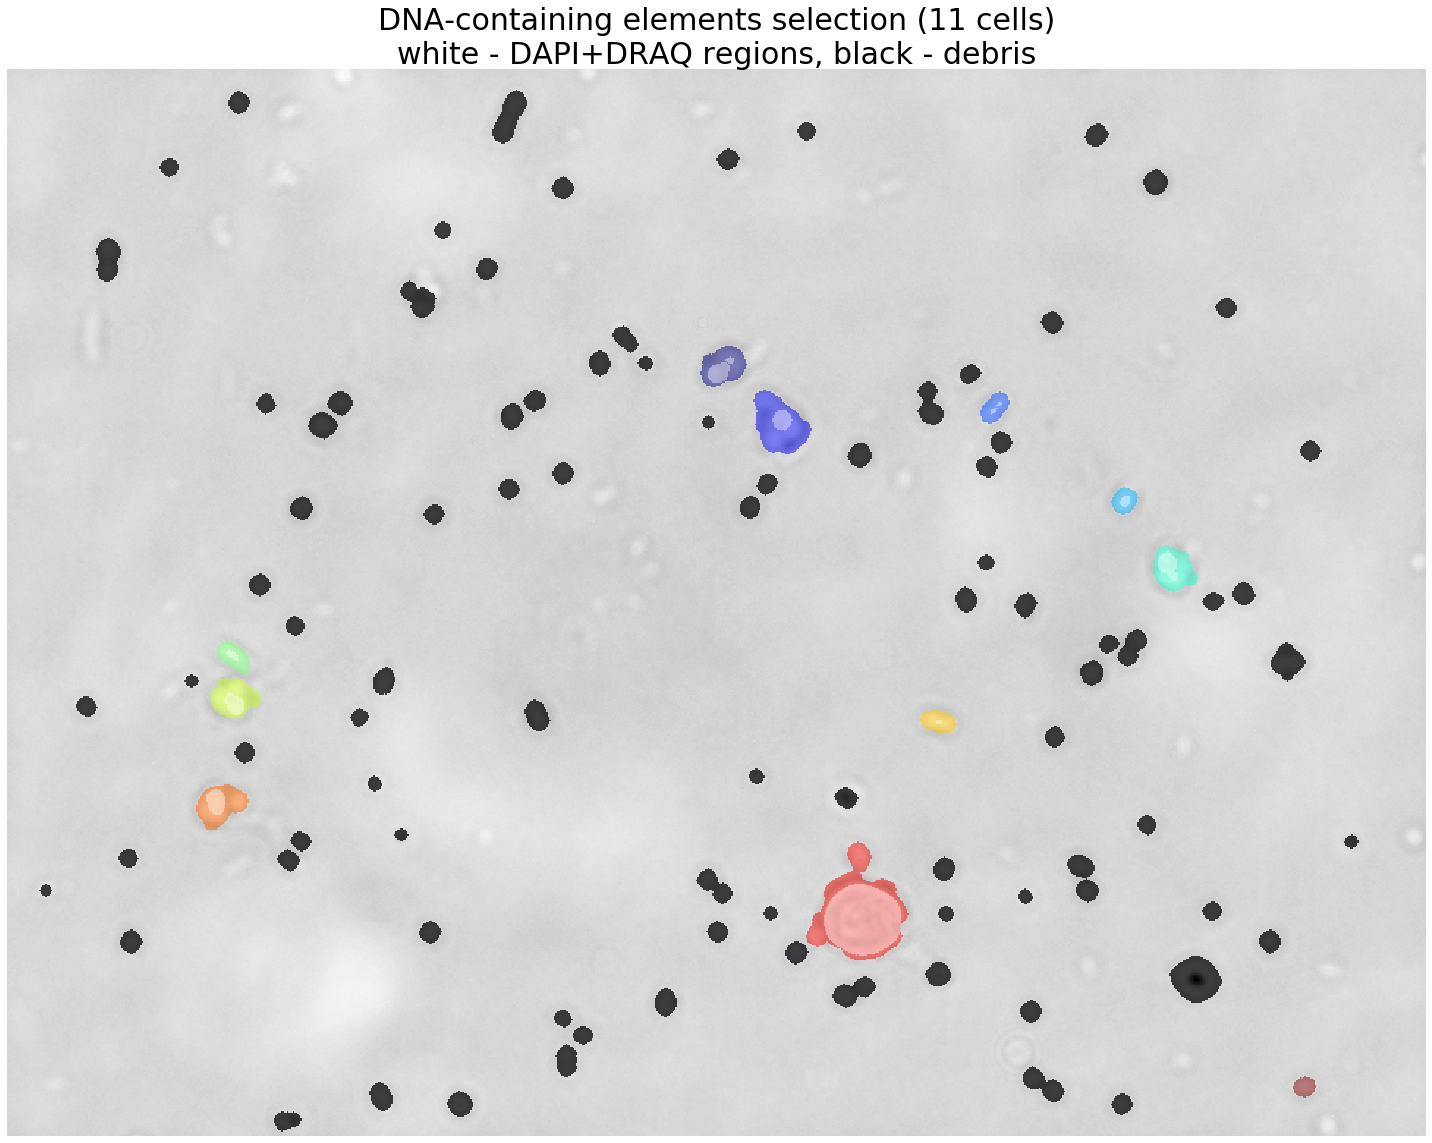

In [198]:
# masking by trans img
img_trans_filt = filters.gaussian(img_trans, sigma=2)

img_trans_filt = img_trans_filt / np.max(np.abs(img_trans_filt))
img_trans_filt = filters.rank.gradient(img_trans_filt, morphology.disk(3))

mask = img_trans_filt > filters.threshold_otsu(img_trans_filt)
mask = ndi.binary_fill_holes(mask)
mask = segmentation.clear_border(mask)

mask = morphology.erosion(mask, footprint=morphology.disk(5))
mask = morphology.dilation(mask, footprint=morphology.disk(4))

labels, labels_num = ndi.label(mask)

# debris filtering
ctrl_fluo_img = img_dapi + img_draq
ctrl_fluo_mask = ctrl_fluo_img > filters.threshold_otsu(ctrl_fluo_img)

sums = ndi.sum(ctrl_fluo_mask, labels, np.arange(labels_num+1))
connected = sums > 0
debris_mask = connected[labels]

# final mask filtering
fin_mask = np.copy(mask)
fin_mask[~debris_mask] = 0  # debris rejection
fin_mask[ctrl_fluo_mask] = 1  # holes filling with DAPI+DRAQ mask
fin_mask = segmentation.clear_border(fin_mask)  # borders cleaning
fin_mask = morphology.opening(fin_mask, footprint=morphology.disk(5))  # rejection of DAPI+DRAW mask artifacts
fin_mask = ndi.binary_fill_holes(fin_mask)

cells_labels, cells_num = ndi.label(fin_mask)


plt.figure(figsize=(20,20))

ax1 = plt.subplot()
ax1.imshow(img_trans, cmap='Greys')
ax1.imshow(ma.masked_where(~fin_mask, cells_labels), cmap='jet', alpha=.5)
ax1.imshow(ma.masked_where(~ctrl_fluo_mask, ctrl_fluo_mask), cmap='Greys', alpha=.4)
ax1.imshow(ma.masked_where(debris_mask, ~debris_mask), cmap='magma', alpha=.75)
ax1.axis('off')
ax1.set_title(f'DNA-containing elements selection ({cells_num} cells)\nwhite - DAPI+DRAQ regions, black - debris',
              fontsize=30)

plt.tight_layout()
plt.show()

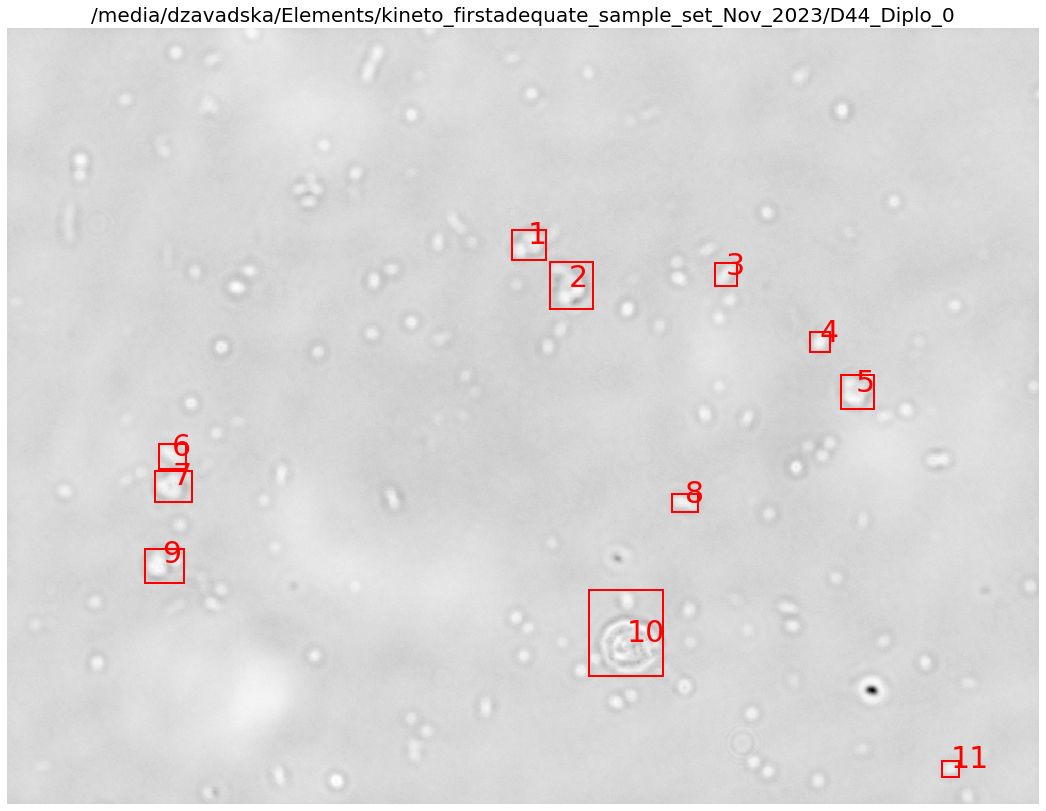

In [199]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_trans, cmap='Greys')
ax.set_axis_off()
ax.set_title('Cells regions')

cells_list = []
for region in measure.regionprops(cells_labels):
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=30)

plt.title(img_name, fontsize=20)
plt.tight_layout()
plt.show()

## DEMO

In [200]:
class OneCell():
    def __init__(self, cell_num, dapi_img, draq_img, trans_img, cell_mask):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask
        self.cell_contour = measure.find_contours(self.cell_mask, level=0.5)

        self.dapi_img = dapi_img
        self.dapi_img[~self.cell_mask] = np.mean(self.dapi_img, where=~self.cell_mask)
        self.draq_img = draq_img
        self.draq_img[~self.cell_mask] = np.mean(self.draq_img, where=~self.cell_mask)
        self.trans_img = trans_img


        
        self.zeros = np.zeros_like(self.cell_mask)

        self.min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), clip=False)

        self.dapi_norm = self.min_max_scaler.fit_transform(self.dapi_img.reshape(-1,1)).reshape(self.dapi_img.shape)
        self.draq_norm = self.min_max_scaler.fit_transform(self.draq_img.reshape(-1,1)).reshape(self.draq_img.shape)    
        self.raw_overlay = np.stack([self.draq_norm, self.zeros, self.dapi_norm], axis=-1)

        self.qd_rel = np.divide(self.draq_norm, self.dapi_norm, out=np.zeros_like(self.draq_norm), where=self.dapi_norm!=0)
        self.qd = self.draq_img * self.qd_rel
        self.dq_rel = np.divide(self.dapi_norm, self.draq_norm, out=np.zeros_like(self.dapi_norm), where=self.draq_norm!=0)
        self.dq = self.dapi_img * self.dq_rel

        self.qd_norm = self.min_max_scaler.fit_transform(self.qd.reshape(-1,1)).reshape(self.qd.shape)
        self.dq_norm = self.min_max_scaler.fit_transform(self.dq.reshape(-1,1)).reshape(self.dq.shape)
        self.rel_overlay = np.stack([self.qd_norm, self.zeros, self.dq_norm], axis=-1)

        self.rel_rel = np.divide(self.dq_norm, self.qd_norm, out=np.zeros_like(self.dq_norm), where=self.qd_norm!=0)

        
        ###omitting single pixels with maximum intensity which appear as artefacts - substituting everything which is =1 by mean from self.qd_norm
        # - only in case if there are only 1/2/0 pixels with intensity = 1 (D)
        #HELP IF YOU GOT ANY SMARTER SOLUTIONNNNNNN
        if (len(np.where(self.qd_norm == 1))) <= 2:                    
            self.qd_norm[self.qd_norm == 1] = np.mean(self.qd_norm)
        if (len(np.where(self.dq_norm == 1))) <= 2:                    
            self.qd_norm[self.dq_norm == 1] = np.mean(self.dq_norm)
        
        ###making contours masks for kDNA and nuclei
        self.nucl_otsu = threshold_multiotsu(self.qd_norm,classes = 2)
        self.nucl_otsu_contours = np.digitize(self.qd_norm, bins=self.nucl_otsu)
        #opening is subject to question and change!!!!!!!!!!!! - initially added to remove noise sindle pixels not connected w nucleus 
        self.nucl_otsu_contours = morphology.opening(self.nucl_otsu_contours, morphology.disk(1))
        #plt.imshow(self.nucl_otsu_contours) #debug plot
        
        self.k_otsu = threshold_multiotsu(self.dq_norm,classes = 2)
        self.k_otsu_contours = np.digitize(self.dq_norm, bins=self.k_otsu)
        #erosion is subject to question and change!!!!!!!!!!!!
        self.k_otsu_contours = morphology.erosion(self.k_otsu_contours, morphology.disk(2))
        #plt.imshow(self.k_otsu_contours) #debug plot

        
        
        ### Taking original DRAQ image, substractin mean of non-nucleus and non-kDNA intensity to normalise
        #mean intensity of nucleus and kDNA
        self.nucleus_raw_int = np.mean(self.draq_img, where=self.nucl_otsu_contours > 0)
        self.k_raw_int = np.mean(self.draq_img, where=self.k_otsu_contours > 0)
        print('nucleus/kDNA mean raw intensity')
        print(np.mean(self.draq_img, where=self.nucl_otsu_contours > 0))
        print(np.mean(self.draq_img, where=self.k_otsu_contours > 0))

        #print(np.mean(self.draq_img)) # -- control that bg+cyt are not taken into account! (uncomment for debug)
        
        #mean intensity of bg+cyt
        self.no_feature = self.draq_img
        self.no_feature[self.k_otsu_contours.astype(np.bool)] = 0
        self.no_feature[self.nucl_otsu_contours.astype(np.bool)] = 0
        
        print('background+cytoplasm mean raw intensity')
        print(np.mean(self.no_feature, where=self.no_feature > 0))
        #print(np.mean(self.no_feature)) # -- control that features are not taken into account! (uncomment for debug)
        #plt.imshow(self.no_feature) #debug plot
        
        
        
        
        self.nucleus_norm_int = self.nucleus_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
        self.k_norm_int = self.k_raw_int - (np.mean(self.no_feature, where=self.no_feature > 0))
        
        print('nucleus mean normalised intensity', self.nucleus_norm_int , ' kDNA mean normalised intensity ', self.k_norm_int)
        
        
        
    def pic_3d(self):
        xx, yy = np.mgrid[0:self.cell_mask.shape[0], 0:self.cell_mask.shape[1]]

        import plotly.graph_objects as go
        from plotly.offline import iplot

        data = [go.Surface(x=xx,y=yy,z=self.draq_norm,
                        colorscale='Reds', opacity=0.65, showscale=False),
                go.Surface(x=xx,y=yy,z=self.dapi_norm,
                        colorscale='Blues', opacity=0.65, showscale=False)]
        iplot(data)


    def pic_grid(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(234)
        ax0.imshow(self.qd_norm, vmin=0, vmax=1, cmap='jet')
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('QD (DRAQ/DAPI * DRAQ)')
        ax0.axis('off')

        ax2 = plt.subplot(233)
        ax2.imshow(self.draq_norm, vmin=0, vmax=1, cmap='jet')
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax2.set_title('DRAQ')
        ax2.axis('off')

        ax1 = plt.subplot(232)
        ax1.imshow(self.dq_norm, vmin=0, vmax=1, cmap='jet')
        for ce_c in self.cell_contour:
            ax1.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax1.set_title('DQ (DAPI/DRAQ * DAPI)')
        ax1.axis('off')

        ax3 = plt.subplot(231)
        ax3.imshow(self.dapi_norm, vmin=0, vmax=1, cmap='jet')
        for ce_c in self.cell_contour:
            ax3.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax3.set_title('DAPI')
        ax3.axis('off')
        
        ax4 = plt.subplot(235)
        ax4.imshow(self.nucl_otsu_contours, vmin=0, vmax=1, cmap='jet')
        ax4.set_title('Nucleus area')
        ax4.axis('off')
        
        ax4 = plt.subplot(236)
        ax4.imshow(self.k_otsu_contours, vmin=0, vmax=1, cmap='jet')
        ax4.set_title('kDNA area')
        ax4.axis('off')
        
        
        plt.show()


    def pic_overlay(self):
        plt.figure(figsize=(15,15))

        ax0 = plt.subplot(211)
        ax0.imshow(self.raw_overlay)
        for ce_c in self.cell_contour:
            ax0.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax0.set_title('Raw')
        ax0.axis('off')

        ax2 = plt.subplot(212)
        ax2.imshow(self.rel_overlay)
        for ce_c in self.cell_contour:
            ax2.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1.5, color='w')
        ax2.set_title('Rel')
        ax2.axis('off')

    
    def pic_px_plot(self):
        plt.scatter(self.dapi_norm.ravel(), self.draq_norm.ravel(),
            color='b', alpha=.1, label='Raw')
        plt.scatter(self.dq_norm.ravel(), self.qd_norm.ravel(),
                    color='r', alpha=.1, label='Rel')
        plt.xlabel('DAPI or DQ')
        plt.ylabel('DRAQ or QD')
        plt.legend()
        plt.show()


for region in measure.regionprops(cells_labels):
    if region.label == 7:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=2)
        demo_cell = OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_mask[minr:maxr, minc:maxc])

nucleus/kDNA mean raw intensity
31278.254385964912
14137.153846153846
background+cytoplasm mean raw intensity
10604.226703755216
nucleus mean normalised intensity 20674.027682209697  kDNA mean normalised intensity  3532.92714239863


/tmp/ipykernel_47650/2409399886.py:71: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.k_otsu_contours.astype(np.bool)] = 0
/tmp/ipykernel_47650/2409399886.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.no_feature[self.nucl_otsu_contours.astype(np.bool)] = 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


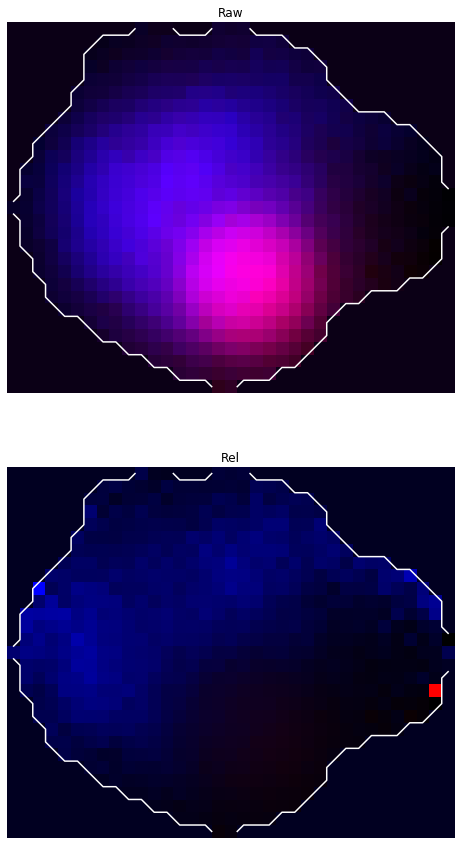

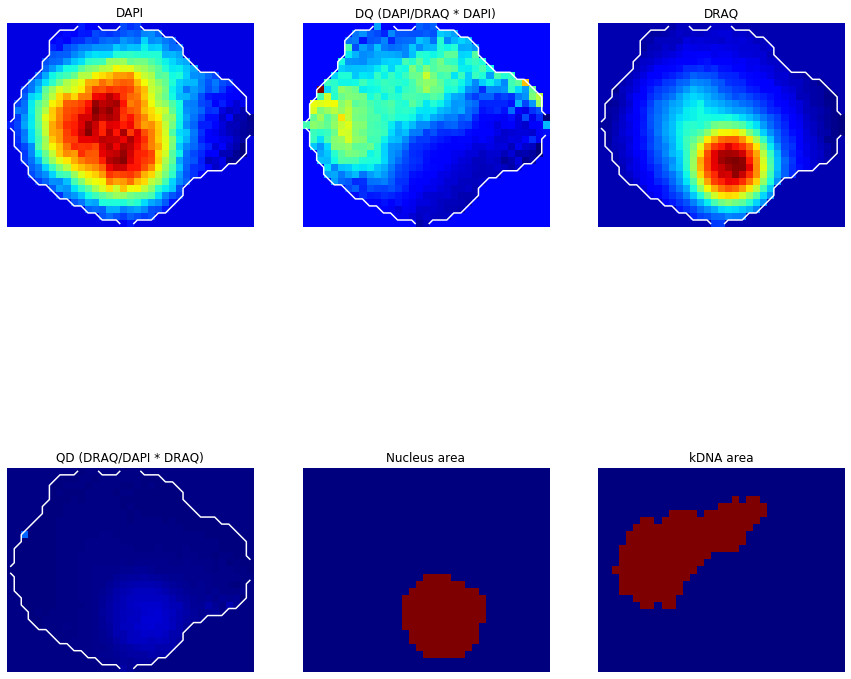

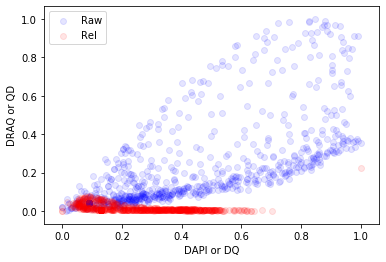

In [201]:
demo_cell.pic_overlay()
demo_cell.pic_grid()
demo_cell.pic_px_plot()

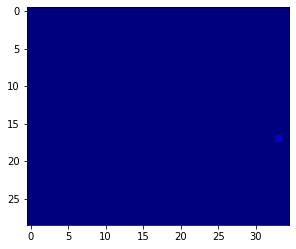

In [138]:
plt.imshow(demo_cell.qd_rel, cmap='jet', vmin=0, vmax=np.max(demo_cell.rel_rel, where=demo_cell.cell_mask, initial=-1))

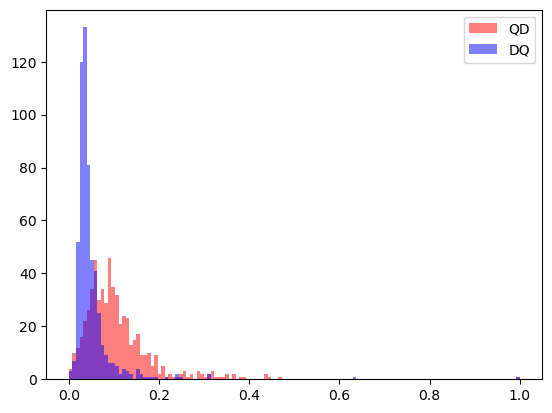

In [61]:
plt.hist(demo_cell.qd_norm.ravel(), bins=127, range=(0,1), color='r', alpha=.5, label='QD')
plt.hist(demo_cell.dq_norm.ravel(), bins=127, range=(0,1), color='b', alpha=.5, label='DQ')
plt.legend()
plt.show()

## Cells separation

#### Class for individual cells (OLD VERSION)

In [ ]:
class OneCellOld():
    def __init__(self, cell_num, dapi_img, dapi_sum_img, draq_img, draq_sum_img, trans_img, cell_mask, **kwargs):
        self.cell_num = cell_num
        self.cell_species = 'NA'
        self.cell_mask = cell_mask

        self.dapi_img = dapi_img
        self.draq_img = draq_img
        self.trans_img = trans_img

        self.dapi_sum_img = dapi_sum_img
        self.draq_sum_img = draq_sum_img

        self.dapi_norm = (self.dapi_img - np.min(self.dapi_img)) / (np.max(self.dapi_img) - np.min(self.dapi_img))
        self.draq_norm = (self.draq_img - np.min(self.draq_img)) / (np.max(self.draq_img) - np.min(self.draq_img))
        zeros = np.zeros_like(self.dapi_norm)

        self.rgb_overlay = np.stack([self.draq_norm, zeros, self.dapi_norm], axis=-1)  # red - DAPI, green - Draq5

        # nDNA/kDNA masking
        self.k_mask, self.n_mask, self.kn_label, self.kn_mask, self.mask_qual = self.create_kineto_mask(dapi_norm=self.dapi_norm,
                                                                                                        draq_norm=self.draq_norm,
                                                                                                        **kwargs)
         
    
    @staticmethod
    def create_kineto_mask(dapi_norm, draq_norm, filter_n=False, show_debug_img=False):
        diff_img = dapi_norm - draq_norm
        sum_img = draq_norm + dapi_norm

        # kDNA masking
        k_mask_raw = diff_img > filters.threshold_otsu(diff_img)
        k_mask = morphology.opening(k_mask_raw, morphology.disk(1))

        # nDNA masking
        n_mask_raw = sum_img > filters.threshold_otsu(sum_img)
        n_mask_raw[k_mask] = 0
        if filter_n:
            n_mask = morphology.erosion(n_mask_raw, morphology.disk(1))
        else:
            n_mask = n_mask_raw

        mask_q = ''
        if np.sum(k_mask) > np.size(n_mask) * 0.5:
            mask_q = '(bad mask)'

        kn_label = np.zeros_like(dapi_norm)
        kn_label[k_mask] = 1
        kn_label[n_mask] = 2

        kn_mask = kn_label != 0

        if show_debug_img:
            plt.figure(figsize=(15,15))

            ax0 = plt.subplot(231)
            ax0.imshow(diff_img)
            ax0.set_title('DAPI-Draw5  (diff img)')
            ax0.axis('off')

            ax5 = plt.subplot(232)
            ax5.imshow(sum_img)
            ax5.set_title('DAPI+Draw5  (summ img)')
            ax5.axis('off')

            ax1 = plt.subplot(233)
            ax1.imshow(k_mask_raw)
            ax1.set_title('k mask raw')
            ax1.axis('off')

            ax2 = plt.subplot(234)
            ax2.imshow(k_mask)
            ax2.set_title('k mask')
            ax2.axis('off')

            ax3 = plt.subplot(235)
            ax3.imshow(n_mask_raw)
            ax3.set_title('n mask raw')
            ax3.axis('off')

            ax3 = plt.subplot(236)
            ax3.imshow(n_mask)
            ax3.set_title('n mask')
            ax3.axis('off')

            plt.tight_layout()
            plt.show()

        return k_mask, n_mask, kn_label, kn_mask, mask_q


    def create_kineto_mask_old(self):
        """ previous detection method
        
        """ 
        

        diff = self.dapi_norm - self.draq_norm

        self.k_mask_raw = diff > filters.threshold_otsu(diff)

        diff_masked = ma.masked_where(~self.k_mask_raw, diff)

        self.k_mask = diff > filters.threshold_otsu(diff_masked.compressed())

        self.n_mask = self.draq_norm > filters.threshold_otsu(self.draq_norm)

        if np.sum(self.k_mask) > np.size(diff) * 0.5:
            print("Bad mask")

        self.kn_label = np.zeros_like(self.dapi_img)
        self.kn_label[self.k_mask] = 1
        self.kn_label[self.n_mask] = 2

        self.kn_mask = self.kn_label != 0

        plt.figure(figsize=(10, 10))
        plt.imshow(self.trans_img, cmap='Greys')
        plt.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        plt.title('Red-nucleus')
        plt.axis('off')

        plt.show()
        
        
    def ctrl_masks_img(self):
        plt.figure(figsize=(15,5))

        ax0 = plt.subplot(131)
        ax0.imshow(self.trans_img, cmap='Greys')
        ax0.imshow(ma.masked_where(~self.cell_mask, self.cell_mask), cmap='jet', alpha=.3)
        ax0.set_title('Trans ch. with cell mask overlay')
        ax0.axis('off')

        ax1 = plt.subplot(132)
        ax1.imshow(self.rgb_overlay)
        ax1.set_title('DAPI-blue, Draq5-red')
        ax1.axis('off')

        ax2 = plt.subplot(133)
        ax2.imshow(self.trans_img, cmap='Greys')
        # plt.imshow(self.k_regions, cmap='bwr', alpha=.3)
        ax2.imshow(ma.masked_where(~self.kn_mask, self.kn_label), cmap='bwr', alpha=.3)
        ax2.set_title('Red-nDNA, blue-kDNA')
        ax2.axis('off')

        plt.suptitle(f'Cell {self.cell_num} {self.mask_qual}')
        plt.tight_layout()
        plt.show()


    def calc_cell_parameters(self):
        cell_df = pd.DataFrame({'num':self.cell_num,
                                'species':self.cell_species,
                                'cell_area':np.sum(self.cell_mask),
                                'kDNA_int':np.sum(self.dapi_sum_img, where=self.k_mask),
                                'kDNA_area':np.sum(self.k_mask),
                                'nDNA_int':np.sum(self.draq_sum_img, where=self.n_mask),
                                'nDNA_area':np.sum(self.n_mask)},
                                index=[0])

        return cell_df


### Loop over cells

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img_trans, cmap='Greys')
ax.set_axis_off()
ax.set_title('Cells regions')

cells_list = []
for region in measure.regionprops(cells_labels):
    # if region.label == 3:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.text(region.centroid[1], region.centroid[0], region.label, color='red', fontsize=20)

    cells_list.append(OneCell(cell_num=region.label,
                            dapi_img=img_dapi[minr:maxr, minc:maxc],
                            dapi_sum_img=img_dapi_sum[minr:maxr, minc:maxc],
                            draq_img=img_draq[minr:maxr, minc:maxc],
                            draq_sum_img=img_draq_sum[minr:maxr, minc:maxc],
                            trans_img=img_trans[minr:maxr, minc:maxc],
                            cell_mask=fin_mask[minr:maxr, minc:maxc],
                            filter_n=False,
                            show_debug_img=False))

plt.tight_layout()
plt.show()

for cell in cells_list:
    cell.ctrl_masks_img()


## Output

### Filtering and species sorting

In [ ]:
species_dict = {1:'A',      # only cells presented in this dict by numbers will be added to good cells list
                3:'A',
                4:'B',
                5:'C'}

good_cells_list = []
for cell in cells_list:
    if cell.cell_num in species_dict.keys():
        cell.cell_species = species_dict[cell.cell_num]
        good_cells_list.append(cell)


### Data frame

In [ ]:
output_df = pd.DataFrame(columns=['num',
                                  'species',
                                  'cell_area',
                                  'kDNA_int',
                                  'kDNA_area',
                                  'nDNA_int',
                                  'nDNA_area'])

for cell in good_cells_list:
    cell_df = cell.calc_cell_parameters()

    output_df = pd.concat([output_df, cell_df],
                           ignore_index=True)

In [ ]:
output_df